In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data

In [2]:
class Encoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc_enc = nn.Linear(n_vis, n_hid)
    def forward(self, v):
        v = torch.relu(self.fc_enc(v))
        return v

class Decoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.fc_dec = nn.Linear(n_hid, n_vis)
    def forward(self, h):
        h = torch.relu(self.fc_dec(h))
        return h
    

class AutoEncoder(nn.Module):
    def __init__(self, n_vis, n_hid):
        super().__init__()
        self.encoder = Encoder(n_vis, n_hid)
        self.decoder = Decoder(n_vis, n_hid)
    
    def encode(self, v):
        return self.encoder(v)
    
    def decode(self, h):
        return self.decoder(h)
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

    def recon_loss(self, tensor):
        batch = tensor.size(0)
        v = tensor.view(batch, -1)
        recon = self.forward(v)
        return F.mse_loss(v, recon)/batch
        

In [3]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [4]:
from torchvision import datasets, transforms

batch_size = 128
n_vis = 784
n_hid = 100
k = 1
n_epochs = 30
lr = 0.01

train_datasets = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
    )
train_loader = torch.utils.data.DataLoader(
    dataset=train_datasets,
    batch_size=batch_size,
    shuffle=True,
)
test_datasets = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor()])
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_datasets,
    batch_size=batch_size,
    shuffle=True
)

In [5]:
from tqdm import tqdm
import numpy as np

device = "cpu"

model = AutoEncoder(n_vis=n_vis, n_hid=n_hid).to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
nfs = []
for epoch in tqdm(range(n_epochs)):
    vv = np.zeros((len(train_datasets), n_hid))

    for idx, (data, target) in enumerate(train_loader):
        n_iter = len(train_loader) * epoch + idx

        
        loss = model.recon_loss(data)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        recon_loss = loss.item()
        test_data = next(iter(test_loader))[0]
        test_recon_loss = model.recon_loss(test_data).item()
        writer.add_scalars(f"Autoencoder/hid_{n_hid}./recon_loss/",{"train": recon_loss, "test": test_recon_loss} ,n_iter)
        vv[idx*batch_size:(idx+1)*batch_size, :] = model.encode(data.view(-1, n_vis)).detach().cpu().numpy()
    nfs.append(vv)

  3%|▎         | 1/30 [00:11<05:38, 11.66s/it]

(0.01, 10)

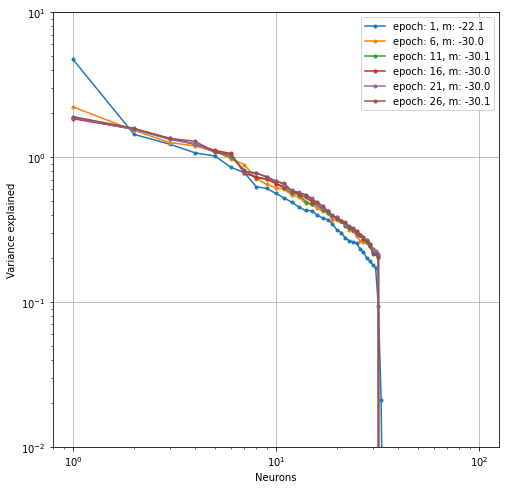

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

fig, ax = plt.subplots(figsize=(8, 8))
xx = np.arange(n_hid) + 1
log_xx = np.log(xx)
# ax.plot(xx, 1000 * xx ** (-1.0))
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Neurons')
ax.set_ylabel('Variance explained')
for i, vv in enumerate(nfs):
    if i % 5 != 0:
        continue
    pca = PCA()
    pca.fit(vv)
    yy = pca.explained_variance_
    log_yy = np.log(yy)
    m, c = np.linalg.lstsq(np.vstack([log_xx, np.ones(len(log_xx))]).T, log_yy, rcond=None)[0]
    ax.plot(xx, yy, '.-', label=f"epoch: {i + 1}, m: {m:.3}")
plt.legend()
ax.grid()


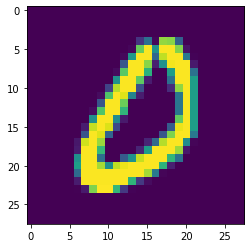

In [ ]:
images = next(iter(test_loader))[0]
plt.imshow(images[0].numpy().reshape(28,28))

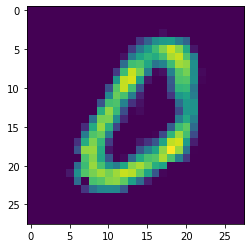

In [ ]:
memorized = model.forward(images.view(batch_size, -1))
plt.imshow(memorized[0].detach().numpy().reshape(28, 28))